# Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from torchaudio.datasets import SPEECHCOMMANDS
import os

# Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Set Dataset

In [3]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [4]:
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


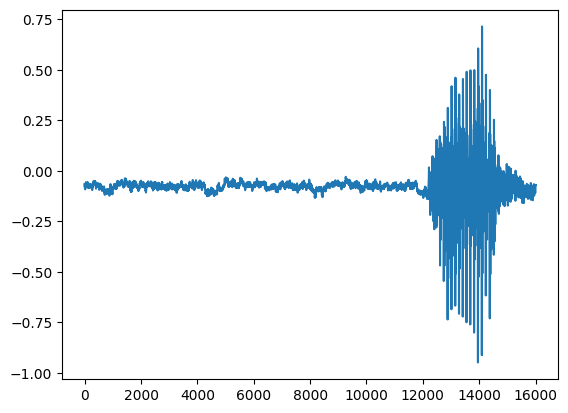

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

In [7]:
waveform_first, sample_rate, utterance, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [8]:
waveform_second,  sample_rate, utterance,*_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [9]:
waveform_last,  sample_rate, utterance,*_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [10]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
waveform = transform(waveform)

# Set Spectogram

In [12]:
spectrogram = torchaudio.transforms.Spectrogram()(waveform)

mean = torch.mean(spectrogram)
std = torch.std(spectrogram)
spectrogram = (spectrogram - mean) / std

In [13]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [14]:
word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [15]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    # Assume input shape: (batch_size, channels, time)
    batch = [item.unsqueeze(0) for item in batch]  # Add channel dimension
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)  # Reshape to (batch_size, time, channels)


def collate_fn(batch):
    tensors, targets = [], []
    max_spec_length = 128  # Tentukan panjang maksimum spektrogram

    # Gather tensors and encode labels as indices
    for waveform, _, label, *_ in batch:
        spectrogram = torchaudio.transforms.Spectrogram()(waveform)

        # Trim or zero-pad the spectrogram to have a fixed length
        if spectrogram.shape[2] > max_spec_length:
            spectrogram = spectrogram[:, :, :max_spec_length]
        else:
            pad_width = max_spec_length - spectrogram.shape[2]
            spectrogram = F.pad(spectrogram, (0, pad_width))

        tensors.append(spectrogram)
        targets.append(label_to_index(label))

    # Group tensors into a batch
    tensors = torch.stack(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [16]:
batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# Model - 2D CNN+Spectogram

In [17]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        self.conv2 = nn.Conv2d(n_channel, n_channel, kernel_size=(3, 3), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(n_channel)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        self.conv3 = nn.Conv2d(n_channel, 2 * n_channel, kernel_size=(3, 3), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(2 * n_channel)
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        self.conv4 = nn.Conv2d(2 * n_channel, 2 * n_channel, kernel_size=(3, 3), padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(2 * n_channel)
        self.pool4 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.adaptive_avg_pool2d(x, 1)  # Global average pooling
        x = x.view(x.size(0), -1)  # Flatten the input for fully connected layer
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)



#model instantiation
model = M5(n_input=1, n_output=len(labels))
model.to(device)
print(model)

M5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=(3, 3), stri

# Count of Parameters

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 67651


# Set Optimizer

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning rate after 20 epochs by a factor of 10

# Set Train Function

In [20]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
            losses.append(loss.item())

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

# Set Test Function

In [21]:
def test(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    print(f"Test set: Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)")

# Training - Testing

  0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.673522
Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.512341
Train Epoch: 1 [10240/84843 (12%)]	Loss: 3.445855
Train Epoch: 1 [15360/84843 (18%)]	Loss: 3.398928
Train Epoch: 1 [20480/84843 (24%)]	Loss: 3.358825
Train Epoch: 1 [25600/84843 (30%)]	Loss: 3.325999
Train Epoch: 1 [30720/84843 (36%)]	Loss: 3.252405
Train Epoch: 1 [35840/84843 (42%)]	Loss: 3.100650
Train Epoch: 1 [40960/84843 (48%)]	Loss: 2.843953
Train Epoch: 1 [46080/84843 (54%)]	Loss: 2.811280
Train Epoch: 1 [51200/84843 (60%)]	Loss: 2.668863
Train Epoch: 1 [56320/84843 (66%)]	Loss: 2.386438
Train Epoch: 1 [61440/84843 (72%)]	Loss: 2.282455
Train Epoch: 1 [66560/84843 (78%)]	Loss: 2.502326
Train Epoch: 1 [71680/84843 (84%)]	Loss: 2.179228
Train Epoch: 1 [76800/84843 (90%)]	Loss: 2.002944
Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.853136
Test set: Accuracy: 3046/11005 (27.68%)
Train Epoch: 2 [0/84843 (0%)]	Loss: 1.900236
Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.670404
Train Epoch: 2 [10240/84

  0%|          | 0/2 [12:55<?, ?it/s]

Test set: Accuracy: 929/11005 (8.44%)


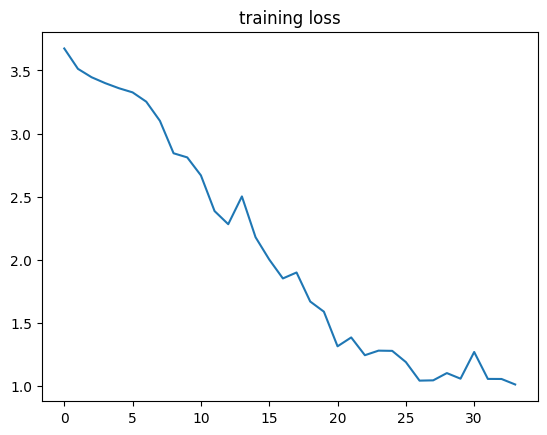

In [23]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model)
        scheduler.step()

#plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

# Prediction

In [74]:
waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [75]:
spectrogram = torchaudio.transforms.Spectrogram()(waveform)

mean = torch.mean(spectrogram)
std = torch.std(spectrogram)
spectrogram = (spectrogram - mean) / std

In [77]:
spectrogram

tensor([[[-0.0970, -0.0971, -0.0970,  ..., -0.0971, -0.0971, -0.0971],
         [-0.0971, -0.0971, -0.0931,  ..., -0.0971, -0.0970, -0.0965],
         [-0.0953, -0.0945, -0.0710,  ..., -0.0968, -0.0952, -0.0966],
         ...,
         [-0.0971, -0.0971, -0.0971,  ..., -0.0971, -0.0971, -0.0971],
         [-0.0971, -0.0971, -0.0971,  ..., -0.0971, -0.0971, -0.0971],
         [-0.0971, -0.0971, -0.0971,  ..., -0.0971, -0.0971, -0.0971]]])

In [78]:
type(spectrogram)

torch.Tensor

In [80]:
pred = model(spectrogram.unsqueeze(0).to(device))

In [81]:
prediction = pred.argmax(dim=1)
prediction = index_to_label(prediction.item())
prediction

'seven'

In [94]:
def predict(tensor):
  spectrogram = torchaudio.transforms.Spectrogram()(waveform)

  mean = torch.mean(spectrogram)
  std = torch.std(spectrogram)
  spectrogram = (spectrogram - mean) / std

  pred = model(spectrogram.unsqueeze(0).to(device))

  prediction = pred.argmax(dim=1)
  prediction = index_to_label(prediction.item())
  return prediction


waveform, sample_rate, utterance, *_ = test_set[-1]

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: four. Predicted: seven.


In [91]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [88]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")

    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Data point #0. Expected: right. Predicted: seven.
